## **Bayesian Learning (revisited)**

Please review Lab2 for the Bayesian Learning.

## **Hidden Markov Models**

Task: Predict stock market using Hidden Markov Models.

Referenced from: [Hidden Markov Models](https://www.kaggle.com/code/ehsanamim/stock-market-prediction-using-hmm)

This link is very useful, so I just copied the code and made some modifications to make it more readable.

In [1]:
# get the stock dataset yfinance
%pip install yfinance -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import yfinance as yf
import numpy as np
import pandas as pd

In [2]:
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01') # get the data from 2010 to 2020

[*********************100%***********************]  1 of 1 completed


In [3]:
display(data.head())

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447411,6.462173,6.398305,6.429938,493729600
2010-01-05,6.458558,6.495011,6.424515,6.465186,601904800
2010-01-06,6.355826,6.484166,6.349198,6.458558,552160000
2010-01-07,6.344077,6.386858,6.297983,6.379326,477131200
2010-01-08,6.386256,6.386859,6.298287,6.335643,447610800


In [4]:
data.shape

(2516, 5)

In [5]:
# split data into train and test
# size 80% train, 20% test
train_size = int(len(data) * 0.8)

# define train and test data
train_data = data[:train_size]
test_data = data[train_size:]

In [6]:
train_data.shape, test_data.shape

((2012, 5), (504, 5))

We are going to be working with 3 features:

- The fractional change in opening and closing prices (fracocp)
- The fractional change in high prices (frachp)
- The fractional change in low prices (fraclp)

In [40]:
def augment_features(dataframe):
    """
    Augment the features of the stock data

    Args:
        dataframe (pd.DataFrame): The stock data

    Returns:
        pd.DataFrame: The stock data with augmented features
    """
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    # convert to 1D dimensional
    fracocp = np.array(fracocp).reshape(-1, 1)
    frachp = np.array(frachp).reshape(-1, 1)
    fraclp = np.array(fraclp).reshape(-1, 1)
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp.flatten(),
                                    'delHighOpen': frachp.flatten(),
                                    'delLowOpen': fraclp.flatten()}, index=dataframe.index)
    
    return new_dataframe

In [41]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [42]:
features = extract_features(augment_features(train_data))

In [43]:
features.shape

(2012, 3)

In [44]:
%pip install hmmlearn


   ---------------------------------------- 0.0/127.0 kB ? eta -:--:--
   --------- ------------------------------ 30.7/127.0 kB ? eta -:--:--
   --------- ------------------------------ 30.7/127.0 kB ? eta -:--:--
   --------------- ----------------------- 51.2/127.0 kB 327.7 kB/s eta 0:00:01
   ------------------------------ ------- 102.4/127.0 kB 658.3 kB/s eta 0:00:01
   -------------------------------------- 127.0/127.0 kB 575.4 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
from hmmlearn.hmm import GaussianHMM

In [46]:
model = GaussianHMM(n_components=10)

In [47]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

In [48]:
import itertools

In [49]:
test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [50]:
num_latent_days = 50
num_days_to_predict = 300

In [57]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.vstack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [06:18<00:00,  1.26s/it]


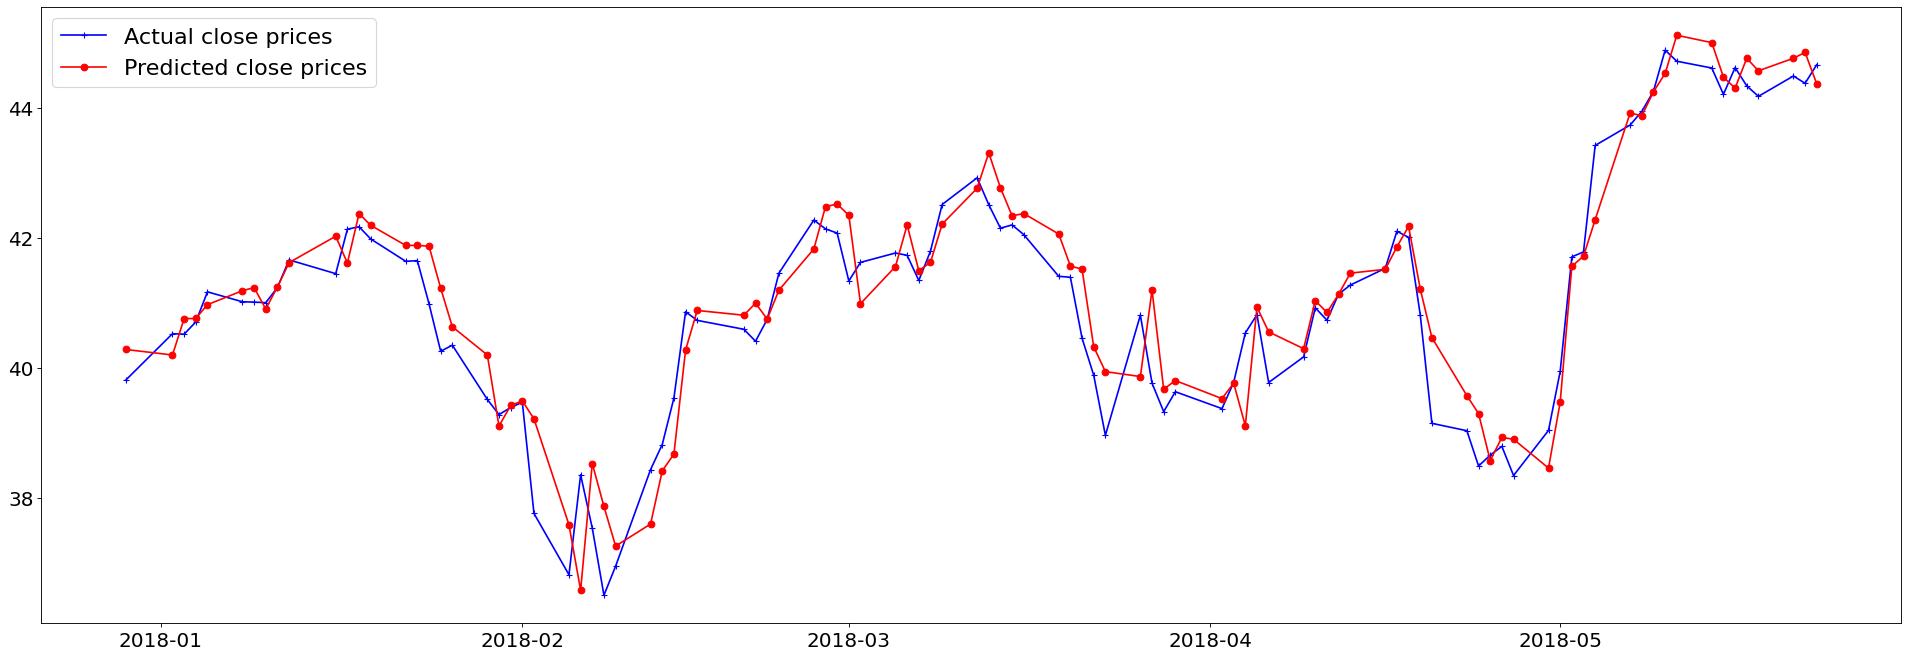

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

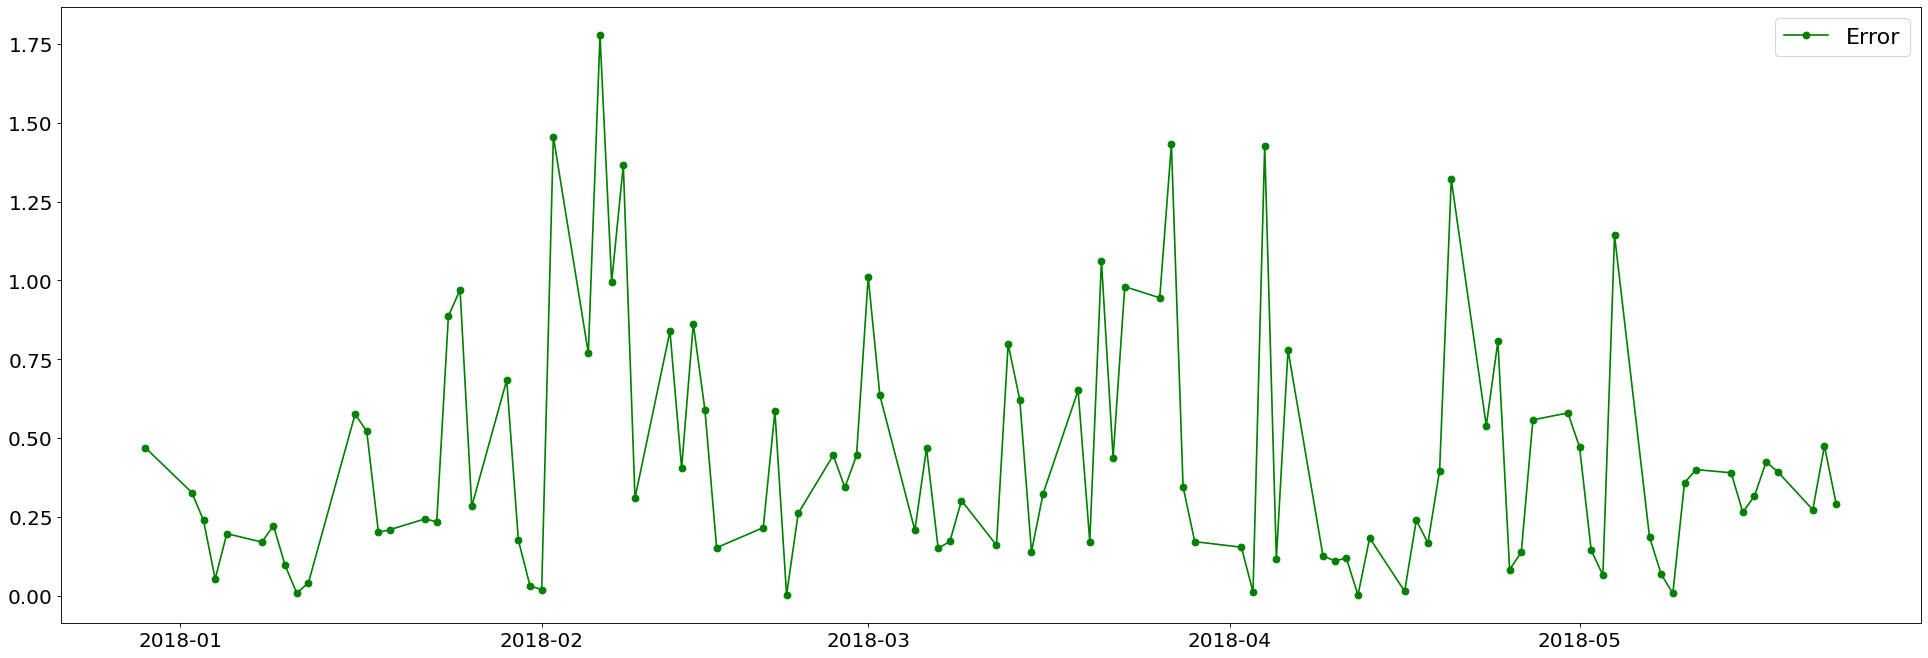

In [75]:
# Calculate the absolute error use temp
ae = np.abs(np.array(test_data.iloc[0:num_days_to_predict]['Close']) - pd.DataFrame(predicted_close_prices))

# Plot the error
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [61]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 2.0994107035710883
Min error observed = 0.0011443770033920941
Mean error observed = 0.4457120017732242


In [62]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 6, 8, 10, 12, 14]
baseline_n_componets = 10
num_steps_values = [10, 20, 40, 50]
baseline_num_steps = 50
num_days_to_predict = 100 # We don't need to predict as many days as before

In [71]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.vstack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score"
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    # copy predicted_close_prices to a temp
    temp = predicted_close_prices.copy()
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - pd.DataFrame(temp)).mean()))

100%|██████████| 100/100 [00:01<00:00, 85.59it/s]


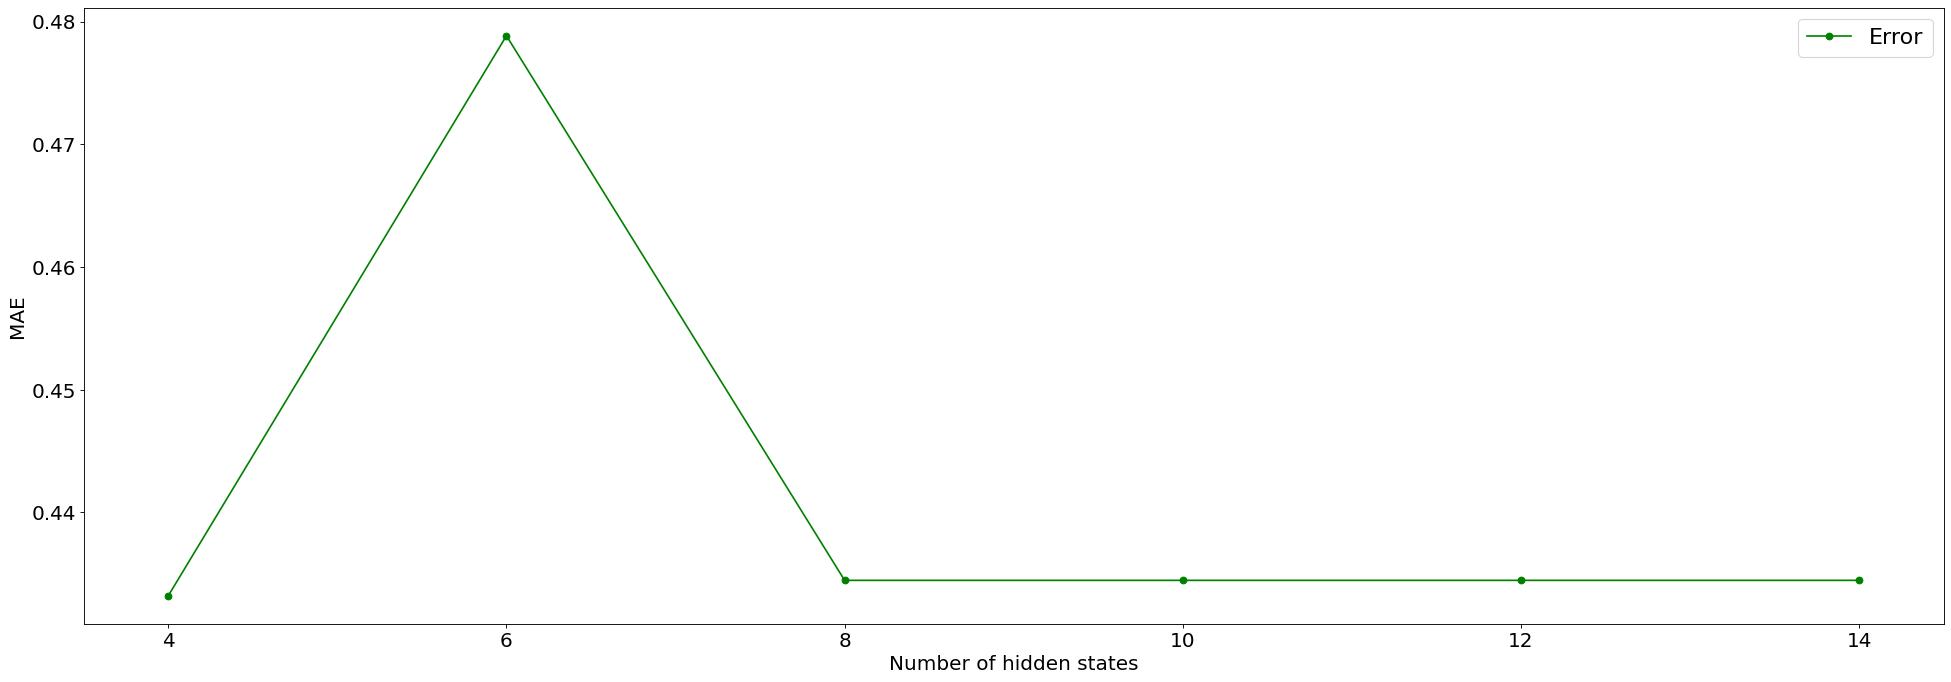

In [72]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

In [76]:
mae_num_steps = []
model = GaussianHMM(n_components=baseline_n_componets)
model.fit(features_train)
for num_step in num_steps_values:
    sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.vstack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_steps.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - pd.DataFrame(predicted_close_prices))).mean())

100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


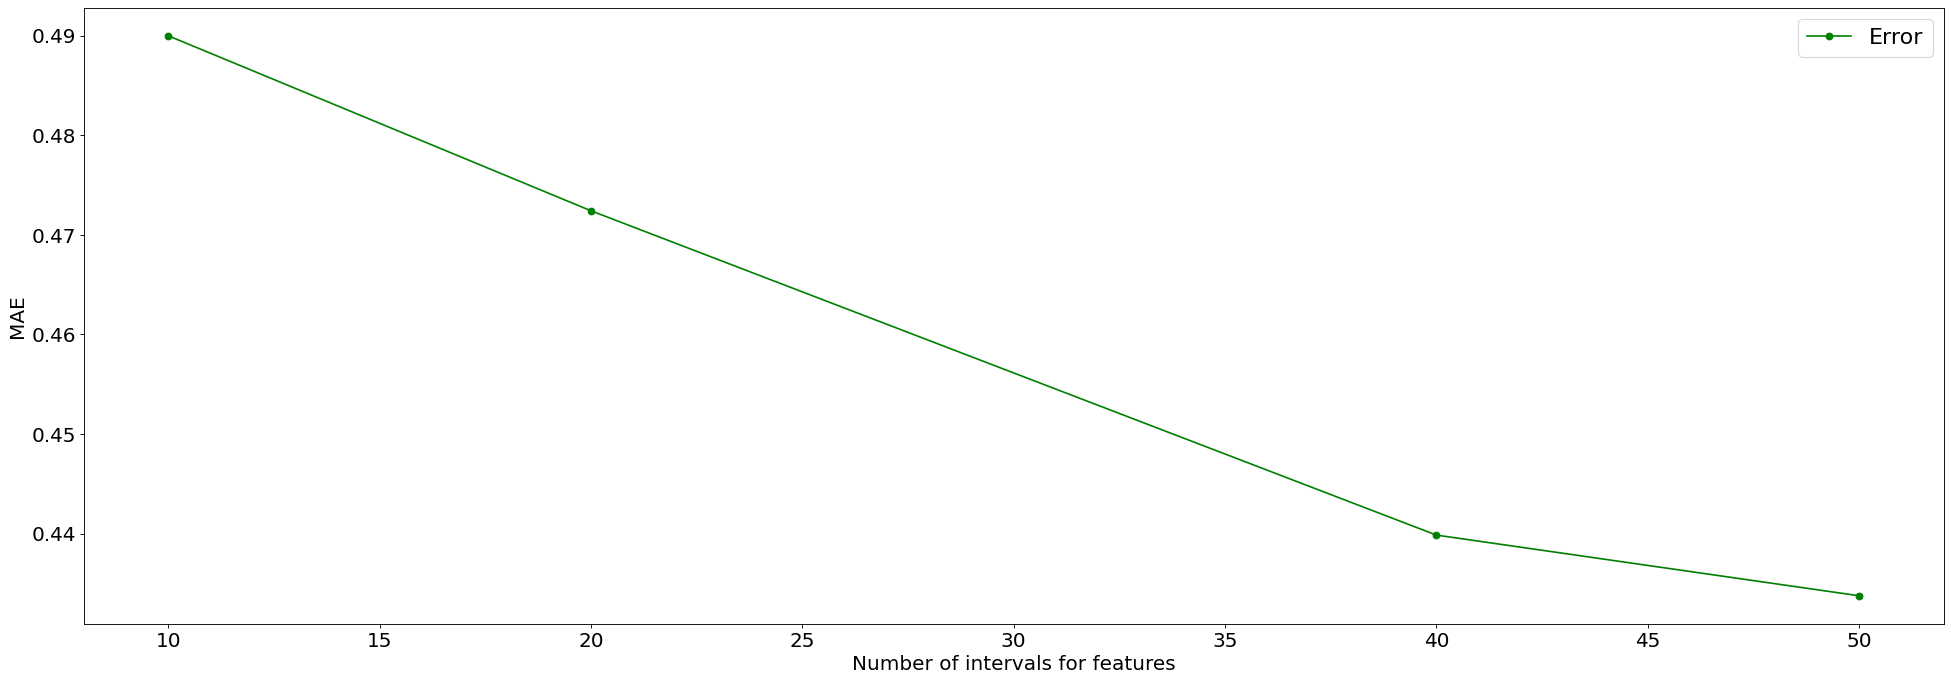

In [77]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(num_steps_values, mae_num_steps, 'go-', label="Error")
plt.xlabel("Number of intervals for features")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()